# Binary networks experiment on toy data classification 

In this notebook we will play a litte with the concept of binary neural networks.

For reference you can go to:

https://arxiv.org/abs/1603.05279

https://arxiv.org/abs/1511.00363

Author: Breno Baldas Skuk



TensorFlow is a free and open-source software library for machine learning and artificial intelligence. It is one of the many options to develop Deep Neural Networks.

Larq is a library that allows us to implement binarized models using tensorflow syntax.

https://github.com/larq/larq

In [ ]:
#Let's install tensorflow and larq.
!pip install tensorflow
!pip install larq

In [ ]:
import tensorflow as tf
import larq as lq
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_circles

# 1. Generate the data

Here we will generate two different sets of points. Once this is done we separate them in training and validation.

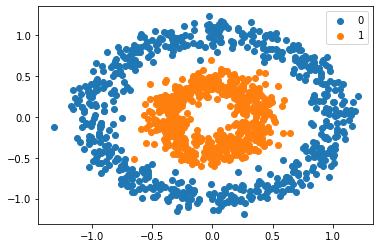

In [ ]:
n_points = 1200
# generate training circles
X, y = make_circles(n_samples=n_points, factor = 0.4, noise=0.1)
# generate validation circles
X_train, y_train = X[:1000], y[:1000]
X_val, y_val = X[1000:1200], y[1000:1200]


# select indices of points with each class label
for i in range(2):
    samples_ix = np.where(y == i)
    plt.scatter(X[samples_ix, 0], X[samples_ix, 1], label=str(i))
plt.legend()
plt.show()

# make labels categorical
y_train = tf.keras.utils.to_categorical( y_train, num_classes=2)
y_val = tf.keras.utils.to_categorical( y_val, num_classes=2)

# 2. Defining architechture

## 2.1 Set binarization parameters

In [ ]:
# All quantized layers except the first will use the same options
kwargs = dict(input_quantizer="ste_sign",
              kernel_quantizer="ste_sign",
              kernel_constraint="weight_clip",
              use_bias=False)


# 2.2 Create sequential tensorflow model

For this experiment we only quantize the weights of the input letting the input be full precision. For the other layers we impose binary inputs and weights.

In [ ]:
model = tf.keras.models.Sequential([
    # In the first layer we only quantize the weights and not the input
    
    lq.layers.QuantDense(10,  kernel_quantizer="ste_sign",
                              kernel_constraint="weight_clip",
                              use_bias=False, input_dim=2),
        
    tf.keras.layers.BatchNormalization(momentum=0.9, scale=False),

    lq.layers.QuantDense(10, **kwargs),
    
    tf.keras.layers.BatchNormalization(momentum=0.9, scale=False),

    lq.layers.QuantDense(2, **kwargs),
        
    tf.keras.layers.BatchNormalization(momentum=0.9, scale=False),
    
    tf.keras.layers.Activation("softmax")
    
])

# 2.3 Binarization ratio and MAC operations

The larq library allows us to measure the binarization ratio and the number of mac operations. This is very important when doing binary models since we want to keep the number of MACs low (compared to a full precision model that does the same task) and the binarization ratio high (close to 1).


In [ ]:
lq.models.summary(model)

+sequential_1 stats--------------------------------------------------------------------------------+
| Layer                  Input prec.   Outputs  # 1-bit  # 32-bit  Memory  1-bit MACs  32-bit MACs |
|                              (bit)                x 1       x 1    (kB)                          |
+--------------------------------------------------------------------------------------------------+
| quant_dense_3                    -  (-1, 10)       20         0    0.00           0           20 |
| batch_normalization_3            -  (-1, 10)        0        20    0.08           0            0 |
| quant_dense_4                    1  (-1, 10)      100         0    0.01         100            0 |
| batch_normalization_4            -  (-1, 10)        0        20    0.08           0            0 |
| quant_dense_5                    1   (-1, 2)       20         0    0.00          20            0 |
| batch_normalization_5            -   (-1, 2)        0         4    0.02           0      

# 3. Training the model 

In [ ]:
model.compile(
    tf.keras.optimizers.Adam(lr=0.01, decay=0.0001),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
trained_model = model.fit(
    X_train, 
    y_train,
    batch_size=50, 
    epochs=40,
    validation_data=(X_val, y_val)
)

Epoch 1/40
20/20 [==============================] - 2s 14ms/step - loss: 0.7845 - accuracy: 0.5270 - val_loss: 0.7573 - val_accuracy: 0.5100
Epoch 2/40
20/20 [==============================] - 0s 4ms/step - loss: 0.6880 - accuracy: 0.6330 - val_loss: 0.6665 - val_accuracy: 0.6500
Epoch 3/40
20/20 [==============================] - 0s 4ms/step - loss: 0.6281 - accuracy: 0.6670 - val_loss: 0.6070 - val_accuracy: 0.6700
Epoch 4/40
20/20 [==============================] - 0s 3ms/step - loss: 0.5756 - accuracy: 0.7040 - val_loss: 0.5460 - val_accuracy: 0.7500
Epoch 5/40
20/20 [==============================] - 0s 4ms/step - loss: 0.5436 - accuracy: 0.7050 - val_loss: 0.5077 - val_accuracy: 0.7400
Epoch 6/40
20/20 [==============================] - 0s 3ms/step - loss: 0.5170 - accuracy: 0.7370 - val_loss: 0.4899 - val_accuracy: 0.7750
Epoch 7/40
20/20 [==============================] - 0s 3ms/step - loss: 0.4790 - accuracy: 0.7620 - val_loss: 0.4127 - val_accuracy: 0.8200
Epoch 8/40
20/20 [=

# 4. Model analysis

We notice that the binarized model seems to perform well. The binerization process can be formalized as a regularization of the network, and we can see here that the model is not overfitting. 

0.9739999771118164
0.9950000047683716


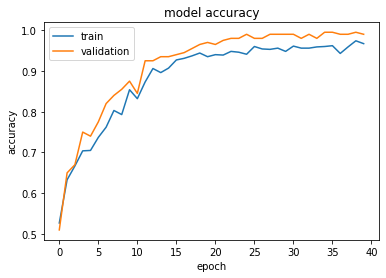

In [ ]:
plt.plot(trained_model.history['accuracy'])
plt.plot(trained_model.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

print(np.max(trained_model.history['accuracy']))
print(np.max(trained_model.history['val_accuracy']))

0.3409940004348755
0.30033791065216064


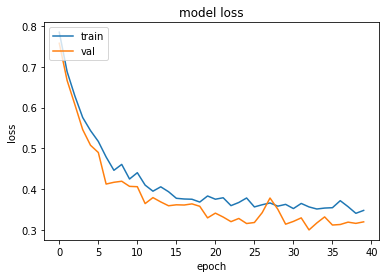

In [ ]:
plt.plot(trained_model.history['loss'])
plt.plot(trained_model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

print(np.min(trained_model.history['loss']))
print(np.min(trained_model.history['val_loss']))

# 5. Let's remove the binarization constraint and train the same architecture!

In [ ]:
model = tf.keras.models.Sequential([
    # In the first layer we only quantize the weights and not the input
    
    tf.keras.layers.Dense(10, use_bias=False, input_dim=2),
        
    tf.keras.layers.BatchNormalization(momentum=0.9, scale=False),

    tf.keras.layers.Dense(10),
    
    tf.keras.layers.BatchNormalization(momentum=0.9, scale=False),

    tf.keras.layers.Dense(2),
        
    tf.keras.layers.BatchNormalization(momentum=0.9, scale=False),
    
    tf.keras.layers.Activation("softmax")
    
])

## 5.1 Mac operations and binarization ratio

Notice that the binarization ratio is zero and the number of MAC operations is still the zame (140)

In [ ]:
lq.models.summary(model)

+sequential_1 stats-----------------------------------------------------------+
| Layer                  Input prec.   Outputs  # 32-bit  Memory  32-bit MACs |
|                              (bit)                 x 1    (kB)              |
+-----------------------------------------------------------------------------+
| dense                            -  (-1, 10)        20    0.08           20 |
| batch_normalization_4            -  (-1, 10)        20    0.08            0 |
| dense_1                          -  (-1, 10)       110    0.43          100 |
| batch_normalization_5            -  (-1, 10)        20    0.08            0 |
| dense_2                          -   (-1, 2)        22    0.09           20 |
| batch_normalization_6            -   (-1, 2)         4    0.02            0 |
| activation_1                     -   (-1, 2)         0       0            ? |
+-----------------------------------------------------------------------------+
| Total                                 

In [ ]:
model.compile(
    tf.keras.optimizers.Adam(lr=0.01, decay=0.0001),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
trained_model = model.fit(
    X_train, 
    y_train,
    batch_size=50, 
    epochs=40,
    validation_data=(X_val, y_val)
)

Epoch 1/40
20/20 [==============================] - 1s 11ms/step - loss: 0.8142 - accuracy: 0.5030 - val_loss: 0.7264 - val_accuracy: 0.5300
Epoch 2/40
20/20 [==============================] - 0s 3ms/step - loss: 0.8130 - accuracy: 0.4840 - val_loss: 0.7690 - val_accuracy: 0.5300
Epoch 3/40
20/20 [==============================] - 0s 3ms/step - loss: 0.8093 - accuracy: 0.4850 - val_loss: 0.7896 - val_accuracy: 0.5200
Epoch 4/40
20/20 [==============================] - 0s 3ms/step - loss: 0.8099 - accuracy: 0.4900 - val_loss: 0.8015 - val_accuracy: 0.5200
Epoch 5/40
20/20 [==============================] - 0s 4ms/step - loss: 0.8097 - accuracy: 0.5000 - val_loss: 0.7985 - val_accuracy: 0.5000
Epoch 6/40
20/20 [==============================] - 0s 3ms/step - loss: 0.8100 - accuracy: 0.5010 - val_loss: 0.7998 - val_accuracy: 0.4950
Epoch 7/40
20/20 [==============================] - 0s 3ms/step - loss: 0.8065 - accuracy: 0.5010 - val_loss: 0.7985 - val_accuracy: 0.5000
Epoch 8/40
20/20 [=

## 5.2 Model analisys

Accuracy is close to 0.5 but this is not good. Remember that we are classifying two classes, so this is the worst result possible.

This full precision model is not working, but the model is not binarized. Can you guess why?


0.5360000133514404
0.5649999976158142


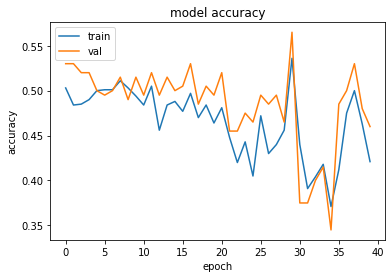

In [ ]:
plt.plot(trained_model.history['accuracy'])
plt.plot(trained_model.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

print(np.max(trained_model.history['accuracy']))
print(np.max(trained_model.history['val_accuracy']))

0.8064600825309753
0.7263796925544739


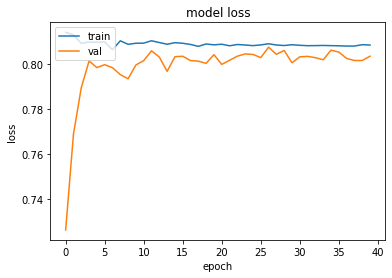

In [ ]:
plt.plot(trained_model.history['loss'])
plt.plot(trained_model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

print(np.min(trained_model.history['loss']))
print(np.min(trained_model.history['val_loss']))

# 6. Adding ReLU to full precision model

The data we are classifying probably needs non linearities. 

Why the binary model did not need them? We model the binarization by introducing a sign function on the input of binarized layers, wich already introduces a non linearity!

Let's try again...



In [ ]:
model = tf.keras.models.Sequential([
    # In the first layer we only quantize the weights and not the input
    
    tf.keras.layers.Dense(10, use_bias=False, input_dim=2),
    
    tf.keras.layers.ReLU(),
    
    tf.keras.layers.BatchNormalization(momentum=0.9, scale=False),
    
    tf.keras.layers.Dense(10),
    
    tf.keras.layers.ReLU(),
    
    tf.keras.layers.BatchNormalization(momentum=0.9, scale=False),

    tf.keras.layers.ReLU(),
    
    tf.keras.layers.Dense(2),
        
    tf.keras.layers.BatchNormalization(momentum=0.9, scale=False),
    
    tf.keras.layers.Activation("softmax")
    
])

## 6.1 Mac operations and binarization ratio

Notice that the number of MAC operations stays the same.

In [ ]:
lq.models.summary(model)

+sequential_2 stats-----------------------------------------------------------+
| Layer                  Input prec.   Outputs  # 32-bit  Memory  32-bit MACs |
|                              (bit)                 x 1    (kB)              |
+-----------------------------------------------------------------------------+
| dense_3                          -  (-1, 10)        20    0.08           20 |
| re_lu                            -  (-1, 10)         0       0            ? |
| batch_normalization_7            -  (-1, 10)        20    0.08            0 |
| dense_4                          -  (-1, 10)       110    0.43          100 |
| re_lu_1                          -  (-1, 10)         0       0            ? |
| batch_normalization_8            -  (-1, 10)        20    0.08            0 |
| re_lu_2                          -  (-1, 10)         0       0            ? |
| dense_5                          -   (-1, 2)        22    0.09           20 |
| batch_normalization_9            -   (

In [ ]:
model.compile(
    tf.keras.optimizers.Adam(lr=0.01, decay=0.0001),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
trained_model = model.fit(
    X_train, 
    y_train,
    batch_size=50, 
    epochs=40,
    validation_data=(X_val, y_val)
)

Epoch 1/40
20/20 [==============================] - 1s 11ms/step - loss: 0.6128 - accuracy: 0.7040 - val_loss: 0.5457 - val_accuracy: 0.8650
Epoch 2/40
20/20 [==============================] - 0s 3ms/step - loss: 0.3928 - accuracy: 0.9560 - val_loss: 0.3550 - val_accuracy: 0.9850
Epoch 3/40
20/20 [==============================] - 0s 3ms/step - loss: 0.3570 - accuracy: 0.9930 - val_loss: 0.3274 - val_accuracy: 1.0000
Epoch 4/40
20/20 [==============================] - 0s 3ms/step - loss: 0.3535 - accuracy: 0.9880 - val_loss: 0.3212 - val_accuracy: 1.0000
Epoch 5/40
20/20 [==============================] - 0s 3ms/step - loss: 0.3471 - accuracy: 0.9870 - val_loss: 0.3168 - val_accuracy: 1.0000
Epoch 6/40
20/20 [==============================] - 0s 3ms/step - loss: 0.3482 - accuracy: 0.9870 - val_loss: 0.3130 - val_accuracy: 1.0000
Epoch 7/40
20/20 [==============================] - 0s 3ms/step - loss: 0.3440 - accuracy: 0.9830 - val_loss: 0.3217 - val_accuracy: 1.0000
Epoch 8/40
20/20 [=

0.9959999918937683
1.0


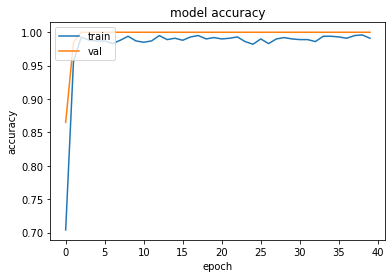

In [ ]:
plt.plot(trained_model.history['accuracy'])
plt.plot(trained_model.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

print(np.max(trained_model.history['accuracy']))
print(np.max(trained_model.history['val_accuracy']))

0.3229571580886841
0.303761750459671


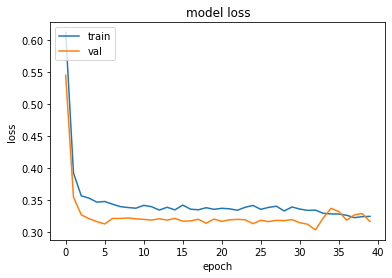

In [ ]:
plt.plot(trained_model.history['loss'])
plt.plot(trained_model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

print(np.min(trained_model.history['loss']))
print(np.min(trained_model.history['val_loss']))

# Conclusion:

Our full precision model works! 

We can observe that the binarization process accounts for non linearities without the need to add ReLU activations.

Furthermore it separates data better than the binarized one.

Now it is your turn to play. Can you reduce the gap between binary and full precision models?

If you want to discuss more you can contact breno.skuk@gmail.com